# EEG Classification using Conv-LSTM model
Here we do hyperparameter grid search by making own GridSearch object and without using library functions or objects (such as GridSearchCV from sklearn). We need to create such an object, because it is not correct to compare neural networks by scores after a fixed number of epochs (due to overfiting and so on) and we need to plot learning curves.

In [1]:
import os
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Conv1D, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from keras import backend as K
from keras.regularizers import l1_l2

from src import data as dt

Using TensorFlow backend.


In [2]:
#import keras.backend as K
#K.tf.device('/gpu:0')
#K.set_session(K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)))

In [2]:
path_to_data = '../sample_data' #'/home/moskaleona/alenadir/data/rawData' #'C:/Users/alena/Desktop/homed/laba/data/rawData' 

In [3]:
data = dt.DataBuildClassifier(path_to_data).get_data([33], shuffle=True, random_state=1, resample_to=128, windows=[(0.2, 0.5)],baseline_window=(0.2, 0.3))

In [4]:
from sklearn.model_selection import train_test_split
X, y = data[33][0], data[33][1]
X_train, X_test, y_train, y_test = train_test_split(data[33][0], data[33][1], test_size=0.2, stratify=data[33][1], random_state=108)

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
import logging

class LossMetricHistory(Callback):
    def __init__(self, n_iter, validation_data=(None,None), verbose=1, filename=None):
        super(LossMetricHistory, self).__init__()
        self.n_iter = n_iter
        self.x_val, self.y_val = validation_data
        self.filename = filename
        if self.x_val is not None and self.y_val is not None:
            self.validate = True
        else:
            self.validate = False
        self.verbose = verbose
        
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.INFO)
        console = logging.StreamHandler()
        console.setLevel(logging.INFO)
        formatter = logging.Formatter("%(message)s")
        console.setFormatter(formatter)
        if len(self.logger.handlers) > 0:
            self.logger.handlers = []
        self.logger.addHandler(console)
            
    
    def on_train_begin(self, logs={}):
        if self.verbose > 0:
            self.logger.info("Training began")
        self.losses = []
        self.val_losses = []
        self.accs = [] # accuracy scores
        self.val_accs = [] # validation accuracy scores
        self.aucs = []# validation ROC AUC scores
        self.sens = []# validation sensitivity (or True Positive Rate) scores
        self.spc = [] # validation specificity scores
        self.thresholds = [] # Decreasing thresholds used to compute specificity and sensitivity
        
        self.maxauc = 0
        self.bestepoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('acc'))
        if self.validate: 
            self.val_losses.append(logs.get('val_loss'))
            self.val_accs.append(logs.get('val_acc'))
            self.y_pred = self.model.predict_proba(self.x_val, verbose=0)
            self.aucs.append(roc_auc_score(self.y_val, self.y_pred))
            
            FPR, TPR, thresholds = roc_curve(self.y_val, self.y_pred)
            self.sens.append(TPR)
            self.spc.append(1-FPR)
            self.thresholds.append(thresholds)
            
            if self.aucs[-1] > self.maxauc:
                self.maxauc = self.aucs[-1]
                self.bestepoch = epoch
                if self.filename is not None:
                    self.model.save(self.filename)
            
            if self.verbose > 0:
                self.logger.info("Epoch %d/%d: train loss = %.6f, test loss = %.6f"%(epoch+1, self.n_iter, 
                                                                    self.losses[-1],self.val_losses[-1]) + 
                                 "\n\tacc = %.6f, test acc = %.6f"%(self.accs[-1], self.val_accs[-1]) +
                                 "\n\tauc = %.6f"%(self.aucs[-1]))
        elif self.verbose > 0:
            self.logger.info("Epoch %d/%d results: train loss = %.6f"%(epoch+1, self.n_iter, self.losses[-1]) + 
                             "\n\t\t\tacc = %.6f"%(self.accs[-1]))
    def on_train_end(self, logs={}):
        self.losses = np.array(self.losses)
        if self.validate:
            self.val_losses = np.array(self.val_losses)
            self.scores = {}
            self.scores['auc'] = np.array(self.aucs)
            self.scores['acc'] = np.array(self.val_accs)
            self.scores['sens'] = np.array(self.sens)
            self.scores['spc'] = np.array(self.spc)
            self.scores['thresholds'] = np.array(self.thresholds)
        

In [6]:
import re
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

class CnnLstmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, loss='binary_crossentropy', n_filters=10, n_lstm=30, n_iter=150,
                 batch_size=10,learning_rate=0.001, l1=0., l2=0.0, dropout=0.,
                 dropout_lstm=0., recurrent_dropout=0., threshold=0.5):
        self.loss = loss
        self.n_lstm = n_lstm
        self.n_filters = n_filters
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.dropout = dropout
        self.dropout_lstm = dropout_lstm
        self.recurrent_dropout = recurrent_dropout
        self.threshold = threshold
        
    def _make_model(self, input_shape):
        batch_input_shape = (None, input_shape[1], input_shape[2])
        self.model = Sequential()
        self.model.add(Conv1D(self.n_filters, self.kernel_size_, batch_input_shape=batch_input_shape,
                         activation='relu', kernel_regularizer=l1_l2(self.l1, self.l2)))
        self.model.add(Dropout(self.dropout))
        self.model.add(LSTM(self.n_lstm,
                       dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def _plot_loss(self,fname=None):
        plt.title('Learning curves')
        plt.xlabel('epoch')
        plt.plot(np.arange(1, len(self.log_.losses)+1),self.log_.losses, color='tab:blue', label='train loss')
        plt.plot(np.arange(1, len(self.log_.val_losses)+1),self.log_.val_losses, color='tab:orange', label='test loss')
        plt.legend()
        if fname is not None:
            plt.savefig(fname)
            plt.clf()
            plt.cla()
        else:
            plt.show()
    
    def _plot_scores(self,scoring,fname=None):
        plt.title('Validation '+scoring)
        plt.xlabel('epoch')
        plt.ylabel(scoring)
        plt.plot(np.arange(1, len(self.log_.aucs)+1),self.log_.aucs, color='b')
        if fname is not None:
            plt.savefig(fname)
            plt.clf()
            plt.cla()
        else:
            plt.show()
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, scoring='auc',n_iter=None,
            verbose=1, plotcurves=False, fname_loss=None, fname_score=None, fname_bestmodel=None):
        # TODO: check the parameters
        if verbose > 0:
            print("Training model with parameters:", self.get_params())
        if n_iter is not None:
            self.n_iter = n_iter
        
        self.kernel_size_ = X_train.shape[2]
        self._make_model(X_train.shape)
        self.optimizer_ = RMSprop(lr=self.learning_rate)
        self.model.compile(loss=self.loss, optimizer=self.optimizer_, metrics=['acc'])
        
        if X_val is not None and y_val is not None:
            self.log_ = LossMetricHistory(n_iter=self.n_iter, 
                                          validation_data=(X_val, y_val), verbose=verbose, filename=fname_bestmodel)
            self.hist_ = self.model.fit(X_train, y_train,
                                        batch_size=self.batch_size,
                                        epochs=self.n_iter, validation_data=(X_val, y_val),
                                        verbose=0, callbacks=[self.log_])
            
            self.best_score_ = self.log_.scores[scoring].max()
            if plotcurves:
                self._plot_loss(fname_loss)
                self._plot_scores(scoring, fname_score)
        else:
            self.log_ = LossMetricHistory(n_iter=self.n_iter)
            self.hist_ = self.model.fit(X_train, y_train,
                                        batch_size=self.batch_size,
                                        epochs=self.n_iter,
                                        verbose=verbose, callbacks=[self.log_])
        self.fit_ = True
        return self
    
    def predict(self, X):
        try:
            getattr(self, "fit_")
        except AttributeError:
            raise RuntimeError("You must train classifier before predicting data!")
        
        proba = self.model.predict(X)
        return (proba > self.threshold).astype('int32')
    
    def predict_proba(self, X):
        
        try:
            getattr(self, "fit_")
        except AttributeError:
            raise RuntimeError("You must train classifier before predicting data!")
        
        return self.model.predict(X)
    
    
    def score(self, X, y, scoring='auc'):
        try:
            if scoring=='auc':
                return roc_auc_score(y, self.predict_proba(X))
            elif scoring=='acc':
                return accuracy_score(y, self.predict(X))
            else:
                raise ValueError(message="No such option: '%s'. Use 'auc' or 'acc'"%str(scoring))
        except ValueError as err:
            print(err)
            
    def set_model(self, model):
        assert \
        str(type(model))=="<class 'keras.models.Sequential'>" or\
        str(type(model))=="<type 'str'>" and re.match(r'.*[^\s]\.hdf5$', filename),\
        "Model type should be keras.models.Sequential or HDF5 file"
        if str(type(model))=="<class 'keras.models.Sequential'>": 
            self.model = model
        else:
            self.model = load_model(model)
        self.n_filters = None
        self.n_lstm = None
        self.kernel_size_ = None
        self.dropout = None
        self.dropout_lstm = None
        self.recurrent_dropout = None
        self.fit_ = True
    

### Testing that everything is working

('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 0.700143, test loss = 0.704361
	acc = 0.581897, test acc = 0.623932
	auc = 0.470476
Epoch 2/3: train loss = 0.605901, test loss = 0.674746
	acc = 0.670259, test acc = 0.675214
	auc = 0.564444
Epoch 3/3: train loss = 0.580283, test loss = 0.720637
	acc = 0.691810, test acc = 0.632479
	auc = 0.498095


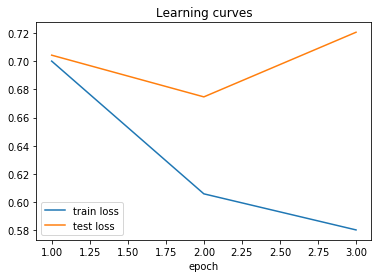

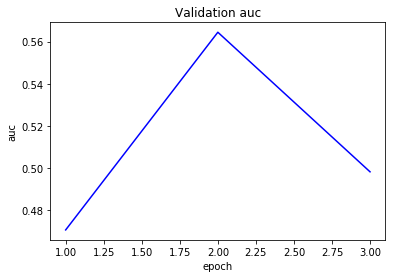

CnnLstmClassifier(batch_size=10, dropout=0.0, dropout_lstm=0.0, l1=0.0,
         l2=0.0, learning_rate=0.001, loss='binary_crossentropy',
         n_filters=10, n_iter=3, n_lstm=30, recurrent_dropout=0.0,
         threshold=0.5)

In [7]:
%matplotlib inline
clf = CnnLstmClassifier(n_iter=3)
clf.fit(X_train, y_train, X_val=X_test, y_val=y_test, verbose=2, plotcurves=True)

## Hyperparameter tuning

In [7]:
from sklearn.model_selection import ParameterGrid
from sklearn.base import clone
from functools import reduce

class GridSearch:
    def __init__(self, estimator, param_grid, scoring='auc',
                 cv=None, verbose=0, plot_scores=True, refit=True):
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        self.plot_scores = plot_scores
        self.refit = refit
    
    def _get_param_iterator(self):
        """Return ParameterGrid instance for the given param_grid"""
        return ParameterGrid(self.param_grid)
    
    def _save_results(self, path, index, fold, estimator):
        if not os.path.isdir(path):
            os.mkdir(path)
        if not os.path.isdir(os.path.join(path, index)):
            os.mkdir(os.path.join(path, index))
        
        path_to_results = os.path.join(path, index, fold)
        if not os.path.isdir(path_to_results):
            os.mkdir(path_to_results)
        
        os.rename(os.path.join(path,'tmp','loss.png'), os.path.join(path_to_results,'loss'+index+'.png'))
        os.rename(os.path.join(path,'tmp','score.png'), os.path.join(path_to_results,self.scoring+index+'.png'))
        os.rename(os.path.join(path,'tmp','model'+index+str(fold)+'.hdf5'),
                  os.path.join(path, index, 'model'+index+str(fold)+'.hdf5'))
        
        params = {self.scoring:estimator.log_.scores[self.scoring],
                'accuracy':estimator.log_.scores[self.scoring],
                'spc':estimator.log_.scores['spc'],
                'sens':estimator.log_.scores['sens'],
                'thresholds':estimator.log_.scores['thresholds']}
            
        np.savez(os.path.join(path_to_results,'scores'+index),
                **params)
    
        
    def fit(self, X_train, y_train, X_test, y_test, groups=None, scoring='auc', path_to_results=None):
        n_splits = cv.get_n_splits(X, y, groups)
        candidate_params = list(self._get_param_iterator())
        n_candidates = len(candidate_params)
        param_names = self.param_grid.keys()
        
        if self.verbose > 0:
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(n_splits, n_candidates,
                                     n_candidates * n_splits))
        if path_to_results is not None:
            saverez = True
            tmp = os.path.join(path_to_results,'tmp')
            if not os.path.isdir(tmp):
                os.mkdir(tmp)
            fname_loss = os.path.join(tmp,'loss.png')
            fname_score = os.path.join(tmp,'score.png')
            
        else:
            saverez = False
            fname_loss = None
            fname_score = None
            if not os.path.isdir('tmp'):
                os.mkdir('tmp')
            tmp = 'tmp'
        
        self.cv_scores_ = np.array([])
        #self.cv_scores_ = []
        self.best_score_ = 0
        idparams = 0
        indices = []
        with open(os.path.join(path_to_results, 'idtopars.csv'), 'w') as idp:
            idp.write(','.join(['id']+[p for p in param_names]))
            idp.write('\n')
        
        for params in candidate_params:
            idparams += 1
            index='{0:04}'.format(idparams)
            indices.append(index)
            #self.cv_scores_.append([])
            fold = 0
            best_n_iters = np.array([])
            for train, val in cv.split(X_train, y_train, groups):
                estimator = clone(self.estimator)
                estimator.set_params(**params)
                estimator.fit(X_train[train], y_train[train], X_val=X_train[val], y_val=y_train[val],
                                scoring=self.scoring, verbose=self.verbose, plotcurves=saverez,
                                fname_loss=fname_loss, fname_score=fname_score,
                                fname_bestmodel=os.path.join(tmp,'model'+index+str(fold)+'.hdf5'))
                best_n_iters = np.append(best_n_iters, estemator.log_.bestepoch)
                #self.cv_scores_[-1].append(estimator.best_score_)
                
                if saverez:
                    self._save_results(path_to_results, index, str(fold), estimator)
                with open(os.path.join(path_to_results, 'idtopars.csv'), 'a') as idp:
                    idp.write(','.join([index]+[str(params[p]) for p in param_names]))
                    idp.write('\n')
                fold += 1
                
            # Testing the best models for each fold on the hold-out data (1)
            # and testing a new model (trained on all the train dataset) 
            # with the average best number of epochs on the hold-out data (2)
            # (1)
            preds1 = np.empty(shape=(X_test.shape[0], n_splits))
            mean_score = 0
            for fold in  range(n_splits):
                if saverez:
                    path_to_model = os.path.join(path_to_results, index, 'model'+index+str(fold)+'.hdf5')
                else:
                    path_to_model = os.path.join(tmp, index, 'model'+index+str(fold)+'.hdf5')
                estimator = clone(self.estimator) 
                estimator.set_model(load_model(path_to_model))
                estimator.set_params(**params)
                preds1[:, fold] = estimator.predict_proba(X_test)[:,0]
                
            K.clear_session()
            
            y_pred1 = preds1.mean(axis=1)
            
            # (2) In process...
            best_n_iter = best_n_iters.mean()
            estimator = clone(self.estimator)
            estimator.set_params(**params)
            estimator.fit(X_train[train], y_train[train], X_val=X_train[val], y_val=y_train[val],
                            scoring=self.scoring, n_iter=best_n_iter, verbose=self.verbose, 
                            plotcurves=saverez,fname_loss=???fname_loss, fname_score=???fname_score,
                            fname_best(last???)model=???os.path.join(tmp,'model'+index+str(fold)+'.hdf5'))
            try:
                if scoring=='auc':
                    score = roc_auc_score(y_test, y_pred)
                elif scoring=='acc':
                    score = accuracy_score(y_test, y_pred)
                else:
                    raise ValueError(message="No such option: '%s'. Use 'auc' or 'acc'"%str(scoring))
            except ValueError as err:
                print(err)
                
            if saverez:
                with open(os.path.join(path_to_results, 'score_table.csv'), 'a') as fout:
                    fout.write(index+','+str(score))
                    fout.write('\n')
                
                fpr, tpr, thresholds = roc_curve(y_test, y_pred)
                np.savez(os.path.join(path_to_results, index, 'final_tpr_fpr_thres'+index), 
                        {'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds})
                plt.title('ROC curve')
                plt.xlabel('FPR')
                plt.ylabel('TPR')
                plt.plot(fpr, tpr)
                plt.savefig(os.path.join(path_to_results, index, 'ROC_curve.png'))
                plt.clf()
                plt.cla()
            
            self.cv_scores_ = np.append(self.cv_scores_, score)
            
        self.best_ind_ = self.cv_scores_.argmax()
        self.best_score_ = self.cv_scores_[self.best_ind_]
        self.best_params_ = candidate_params[self.best_ind_]
        
        if saverez:
            with open(os.path.join(path_to_results, 'score_table.csv'), 'w') as fout:
                ind = np.argsort(self.cv_scores_)
                for i in ind[::-1]:
                    fout.write(indices[i]+','+str(self.cv_scores_[i]))
                    fout.write('\n')
        os.rmdir(tmp)
        
            
        #self.cv_scores_ = reduce(lambda a,b: np.vstack((np.array(a),np.array(b))), self.cv_scores_)
        #self.mean_scores_ = self.cv_scores_.mean(axis=1)
        #self.best_score_ = self.cv_scores_.max()
        #self.best_mean_score_ = self.mean_scores_.max()
        #self.best_ind_ = self.mean_scores_.argmax()
        
        
        '''
        self.best_params_ = candidate_params[self.best_ind_]
        if self.refit:
            if self.verbose > 0:
            print("Grid search is almost done.\n"
                  "Best score is %.6f, best mean score is %.6f.\n"
                  "Now the best estimator is training..."%(self.best_score_, self.best_mean_score_))
            
            self.best_estimator_ = clone(self.estimator).set_params(**self.best_params_)
            self.best_estimator_.fit(X,y)
        '''
        return self
        

In [8]:
'''
param_grid = {
    'n_iter' : [100, 200, 300],
    'l1' : [0., 0.2, 0.4, 0.6],
    'l2' : [0., 0.2, 0.4, 0.6],
    'dropout' : [0., 0.2, 0.4, 0.6],
    'dropout_lstm' : [0., 0.2, 0.4, 0.6],
    'recurrent_dropout' : [0., 0.2, 0.4, 0.6],
}
'''
param_grid = {
    'n_iter' : [3, 2],
    'l1' : [0., 0.2]
}

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
clf = CnnLstmClassifier()
cv = StratifiedShuffleSplit(n_splits=3, test_size = 0.33, random_state = 108)
gs = GridSearch(clf, param_grid, cv=cv, verbose=1)

In [10]:
%%time
gs.fit(X_train, y_train, X_test, y_test, path_to_results='results')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 0.665459, test loss = 0.663981
	acc = 0.606452, test acc = 0.623377
	auc = 0.557943
Epoch 2/3: train loss = 0.625858, test loss = 0.668998
	acc = 0.683871, test acc = 0.629870
	auc = 0.557576
Epoch 3/3: train loss = 0.610198, test loss = 0.669568
	acc = 0.680645, test acc = 0.597403
	auc = 0.554637


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 0.698701, test loss = 0.666905
	acc = 0.538710, test acc = 0.610390
	auc = 0.566758
Epoch 2/3: train loss = 0.634900, test loss = 0.639810
	acc = 0.648387, test acc = 0.655844
	auc = 0.595041
Epoch 3/3: train loss = 0.607467, test loss = 0.631236
	acc = 0.664516, test acc = 0.616883
	auc = 0.606244


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 0.691356, test loss = 0.644965
	acc = 0.632258, test acc = 0.610390
	auc = 0.585124
Epoch 2/3: train loss = 0.618339, test loss = 0.648907
	acc = 0.674194, test acc = 0.655844
	auc = 0.578145
Epoch 3/3: train loss = 0.583220, test loss = 0.668970
	acc = 0.680645, test acc = 0.577922
	auc = 0.552801


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 0.701807, test loss = 0.640706
	acc = 0.535484, test acc = 0.603896
	auc = 0.623508
Epoch 2/2: train loss = 0.637578, test loss = 0.640535
	acc = 0.632258, test acc = 0.623377
	auc = 0.620937


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 0.693211, test loss = 0.677308
	acc = 0.587097, test acc = 0.590909
	auc = 0.526722
Epoch 2/2: train loss = 0.621965, test loss = 0.677240
	acc = 0.687097, test acc = 0.603896
	auc = 0.520845


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 0.659916, test loss = 0.648646
	acc = 0.587097, test acc = 0.642857
	auc = 0.548393
Epoch 2/2: train loss = 0.615282, test loss = 0.669243
	acc = 0.670968, test acc = 0.597403
	auc = 0.490725


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.2, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 24.247075, test loss = 15.179784
	acc = 0.603226, test acc = 0.642857
	auc = 0.615978
Epoch 2/3: train loss = 9.803215, test loss = 5.227187
	acc = 0.625806, test acc = 0.597403
	auc = 0.614141
Epoch 3/3: train loss = 2.889493, test loss = 1.244672
	acc = 0.606452, test acc = 0.642857
	auc = 0.599265


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.2, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 24.987036, test loss = 15.853807
	acc = 0.554839, test acc = 0.642857
	auc = 0.540496
Epoch 2/3: train loss = 10.287341, test loss = 5.525069
	acc = 0.645161, test acc = 0.649351
	auc = 0.577227
Epoch 3/3: train loss = 2.997478, test loss = 1.309677
	acc = 0.664516, test acc = 0.629870
	auc = 0.643159


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.2, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 24.788476, test loss = 15.794339
	acc = 0.587097, test acc = 0.597403
	auc = 0.510927
Epoch 2/3: train loss = 10.362221, test loss = 5.689438
	acc = 0.658065, test acc = 0.649351
	auc = 0.508540
Epoch 3/3: train loss = 3.118126, test loss = 1.404012
	acc = 0.632258, test acc = 0.616883
	auc = 0.515335


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.2, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 24.789808, test loss = 15.836555
	acc = 0.616129, test acc = 0.610390
	auc = 0.385308
Epoch 2/2: train loss = 10.273459, test loss = 5.466824
	acc = 0.641935, test acc = 0.623377
	auc = 0.584206


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.2, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 24.432069, test loss = 15.398808
	acc = 0.570968, test acc = 0.623377
	auc = 0.601469
Epoch 2/2: train loss = 10.010812, test loss = 5.355765
	acc = 0.635484, test acc = 0.629870
	auc = 0.677502


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 2, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.2, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/2: train loss = 25.754223, test loss = 16.528179
	acc = 0.480645, test acc = 0.623377
	auc = 0.476400
Epoch 2/2: train loss = 10.783096, test loss = 5.810811
	acc = 0.645161, test acc = 0.623377
	auc = 0.519008


CPU times: user 1min 51s, sys: 3.1 s, total: 1min 54s
Wall time: 1min 39s


<__main__.GridSearch instance at 0x7f176c85e680>

In [56]:
print(gs.best_estimator_)
print(gs.best_params_)
print(gs.best_score_)

CnnLstmClassifier(batch_size=10, dropout=0.0, dropout_lstm=0.0, l1=0.0,
         l2=0.0, learning_rate=0.001, loss='binary_crossentropy',
         n_filters=10, n_iter=3, n_lstm=30, recurrent_dropout=0.0,
         threshold=0.5)
{'n_iter': 3, 'l1': 0.0}
0.6474608224343114
